In [ ]:
import os
import sys, subprocess
import tensorflow.keras
from keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, Activation, Concatenate, TimeDistributed, RepeatVector, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import gc
import pickle
!pip install nagisa
import nagisa

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !ln -s "/content/drive/My Drive/Projects/" /Projects

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/Projects/Projects': Operation not supported


Load and clean text

In [ ]:
# start with the first 90873
num_example = 90873

# create each languages list
def create_lang_list(num_example):
    # load txt file
    with open('/Projects/combo2.txt', 'r', encoding='UTF-8') as f:
      # get each phrase in both languages
      lines = f.read().strip().split('\n')
      # seperate the phrase in both langauges
      word_pairs = [[phrase for phrase in line.split('\t')]  for line in lines[:num_example]]
      return zip(*word_pairs)


en, ja = create_lang_list(num_example)

ja_sentence = list()
# remove random spaces from the japanese text
for i in ja:
    ja_sentence.append(i.replace(" ", ""))

# space Japanese text
ja_text = list()
for text in ja_sentence:
    words = nagisa.tagging(text)
    ja_text.append(" ".join(words.words).strip())

# Remove accented characters
def english_unicode_to_ascii(text):
     return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

def japanese_unicode_to_ascii(text):
    return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text))

def replace_special_character_to_space_en(text):
    # replaces multiple special char in a row with just one
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    # replaces multiple spaces in row with just one
    text = re.sub(r'[" "]+', " ", text)
    # replaces special char with space
    # text = re.sub(r"[^a-zA-Z?.!,']+", " ", text)
    text = text.lower()
    text = text.strip()
    return text
  
def replace_special_character_to_space(text):
    # replaces multiple special char in a row with just one
    text = re.sub(r"([?!。、¿])", r" \1", text)
    # list of special japanese characters
    pattern = r"[^\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?!\s、。.,0-9]+"
    # remove special characters
    text = re.sub(pattern, '', text).rstrip().strip()
    # remove mulitple spaces
    text = re.sub(r'[" "]+', " ", text)
    text = text.replace("・" , "")
    text = text.lower()
    return text

def normalize(english_text, japanese_text):
    
    input_value = []
    target_value = []
    
    for en_text, ja_text in zip(english_text, japanese_text):
        
        # normalize English
        en_text = english_unicode_to_ascii(en_text)
        en_text = replace_special_character_to_space_en(en_text)
        en_text = "startl " + en_text + " endl"
        target_value.append(en_text)

        # normalize Japanese
        ja_text = japanese_unicode_to_ascii(ja_text)
        ja_text = replace_special_character_to_space(ja_text)

        # add start and end sentence for lstm
        # ja_text = "startl " + ja_text + " endl"
        
        input_value.append(ja_text)

    return input_value, target_value

# get normalize text data
input_value, target_value = normalize(en, ja_text)

# convert to Series
x = pd.Series(input_value) 
y = pd.Series(target_value)

X_train, X_test, \
    Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

print(pd.DataFrame({"input": X_train, "target": Y_train}).head(15))

       input              target
0       行け 。    startl go . endl
1   行き なさい 。    startl go . endl
2    こんにちは 。    startl hi . endl
3     もしもし 。    startl hi . endl
4    やっ ほー 。    startl hi . endl
5    こんにちは !    startl hi . endl
6       走れ 。   startl run . endl
7     走っ て !   startl run . endl
8        誰 ?   startl who ? endl
9     すごい !   startl wow ! endl
10      ワォ !   startl wow ! endl
11      わぉ !   startl wow ! endl
12      おー !   startl wow ! endl
13   火事 だ !  startl fire ! endl
14      火事 !  startl fire ! endl
                                 input                                             target
18680            食物 は 生きる ため に 必要 だ 。            startl food is essential to life . endl
29020      彼 は 彼女 に 自分 の 計画 を 知ら せ た 。      startl he acquainted her with his plan . endl
86442  あなた に 私 の 家族 の 写真 を 送る つもり だ 。  startl i am sending you a picture of my family...
16694                   これ 使っ て も いい ?             startl am i allowed to use this ? endl
49655                 

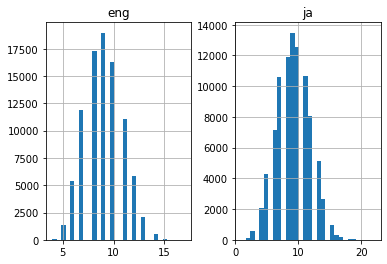

In [ ]:
# empty lists
eng_len = []
ja_len = []

# populate the lists with sentence lengths
for i in x:
      ja_len.append(len(i.split()))

for i in y:
      eng_len.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_len, 'ja':ja_len})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

# prepare Japanese tokenizer
ja_tokenizer = tokenization(x)
with open('ja_tokenizer3.pickle', 'wb') as handle:
    pickle.dump(ja_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
ja_vocab_size = len(ja_tokenizer.word_index) + 1

ja_max_length = max(ja_len)
print('Japanese max sentence length %d' % ja_max_length)
print('Japanese Vocabulary Size: %d' % ja_vocab_size)

# prepare English tokenizer
eng_tokenizer = tokenization(y)
with open('eng_tokenizer3..pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_max_length = max(eng_len)
print('English max sentence length: %d' % eng_max_length)
print('English Vocabulary Size: %d' % eng_vocab_size)

Japanese max sentence length 22
Japanese Vocabulary Size: 14893
English max sentence length: 17
English Vocabulary Size: 9702


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

# prepare training data
trainX = encode_sequences(ja_tokenizer, ja_max_length, X_train)
trainY = encode_sequences(eng_tokenizer, eng_max_length, Y_train)

# prepare validation data
testX = encode_sequences(ja_tokenizer, ja_max_length, X_test)
testY = encode_sequences(eng_tokenizer, eng_max_length, Y_test)

trainX

array([[2166,    2, 1459, ...,    0,    0,    0],
       [   9,    2,   19, ...,    0,    0,    0],
       [  33,    3,   10, ...,    0,    0,    0],
       ...,
       [  10,    6, 1629, ...,    0,    0,    0],
       [  19,    2,   36, ...,    0,    0,    0],
       [2568,    5,   82, ...,    0,    0,    0]], dtype=int32)

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(ja_tokenizer, trainX[0])
print ()
print ("Target Language; index to word mapping")
convert(eng_tokenizer, trainY[0])

Input Language; index to word mapping
2166 ----> 食物
2 ----> は
1459 ----> 生きる
154 ----> ため
3 ----> に
143 ----> 必要
16 ----> だ
1 ----> 。

Target Language; index to word mapping
1 ----> startl
350 ----> food
7 ----> is
2990 ----> essential
5 ----> to
210 ----> life
2 ----> endl


In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      # model.add(Bidirectional(LSTM(512,return_sequences=False, dropout=.2)))
      model.add(Bidirectional(GRU(1024,return_sequences=False)))
      model.add(RepeatVector(out_timesteps))
      # model.add(Bidirectional(LSTM(512,return_sequences=True, dropout=.2)))
      model.add(Bidirectional(GRU(1024,return_sequences=True)))
      model.add(TimeDistributed(Dense(out_vocab,activation='softmax')))
      return model

# model compilation
model = define_model(ja_vocab_size, eng_vocab_size, ja_max_length, eng_max_length, 1024)
learning_rate = 0.002
model.compile(loss = 'sparse_categorical_crossentropy', 
                 optimizer = optimizers.Adam(learning_rate), 
                 metrics = ['accuracy'])

filename = '/content/sample_data/cp_finalApproach-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [ ]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=128, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Epoch 1/20
455/455 [==============================] - ETA: 0s - loss: 2.4283 - accuracy: 0.6293
Epoch 00001: val_loss improved from inf to 2.10537, saving model to /content/sample_data/cp_finalApproach-01.hdf5
455/455 [==============================] - 116s 256ms/step - loss: 2.4283 - accuracy: 0.6293 - val_loss: 2.1054 - val_accuracy: 0.6507
Epoch 2/20
455/455 [==============================] - ETA: 0s - loss: 1.9066 - accuracy: 0.6622
Epoch 00002: val_loss improved from 2.10537 to 1.78488, saving model to /content/sample_data/cp_finalApproach-02.hdf5
455/455 [==============================] - 114s 251ms/step - loss: 1.9066 - accuracy: 0.6622 - val_loss: 1.7849 - val_accuracy: 0.6725
Epoch 3/20
455/455 [==============================] - ETA: 0s - loss: 1.5816 - accuracy: 0.6855
Epoch 00003: val_loss improved from 1.78488 to 1.59406, saving model to /content/sample_data/cp_finalApproach-03.hdf5
455/455 [==============================] - 114s 251ms/step - loss: 1.5816 - accuracy: 0.6855

In [ ]:
model = load_model('/content/sample_data/cp_finalApproach-14.hdf5')

testX = testX[:100]

#trainXsamp = trainX[:100]

preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : Y_test[:100], 'predicted' : preds_text})
pred_df.sample(10)


In [ ]:
# text = "あなたは誰ですか。"
text = "あなたの背が高い"
# text = "あなたの名前は何ですか。"
# text = "彼ならできるでしょうが 。"
# text = "日本料理が好きになった。"

spaced_text = " ".join(word for word in nagisa.tagging(text).words)
spaced_text = "startl " + spaced_text + " endl"
spaced_text = ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', spaced_text))

seq_text = ja_tokenizer.texts_to_sequences([spaced_text])
# pad sequences with 0 values
seq_text = pad_sequences(seq_text, maxlen=40, padding='post')

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
print ("Input Language; index to word mapping")
convert(ja_tokenizer, seq_text[0])

preds = model.predict_classes(seq_text)

def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

print('actual: ' + text + ' predicted: ' + preds_text[0])

Data Sources:

http://www.edrdg.org/wiki/index.php/Tanaka_Corpus
http://www.manythings.org/anki/


Sources:

https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

https://medium.com/voice-tech-podcast/programming-a-machine-translator-ef87fe10606f

https://nthu-datalab.github.io/ml/labs/13-1_Seq2Seq-Learning_Neural-Machine-Translation/13-1_Seq2Seq-Learning_Neural-Machine-Translation.html

https://www.tensorflow.org/tutorials/text/nmt_with_attention

https://towardsdatascience.com/implementing-neural-machine-translation-with-attention-using-tensorflow-fc9c6f26155f

https://github.com/atsushii/Neural-Machine-Translation-Project

